In [18]:
import pickle
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [4]:
data_df = pd.read_excel('ecure_study.xlsx')

data_df.head()

,Sample,txid,inten,time,cure_per,mass_2,mass_4,mass_6,mass_8,mass_10
0,1,00F3FLMV,65,3.5,99.0393,98.884962,98.730624,98.576286,98.421948,98.26761
1,2,00F3FHP2,65,3.5,98.8974,98.743062,98.588724,98.434386,98.280048,98.12571
2,3,00F3FJPN,65,3.5,98.7523,98.597962,98.443624,98.289286,98.134948,97.98061
3,4,00F3FKJS,65,3.5,98.9061,98.751762,98.597424,98.443086,98.288748,98.13441
4,5,00F3FHSM,65,3.5,98.9062,98.751862,98.597524,98.443186,98.288848,98.13451


In [6]:
az.style.use("arviz-darkgrid")

# Predictor Variables
X1 = data_df.inten
X2 = data_df.time

# Outcome Variables based on Mass Adjustments
Y = data_df.cure_per
Y_2 = data_df.mass_2
Y_4 = data_df.mass_4
Y_6 = data_df.mass_6
Y_8 = data_df.mass_8
Y_10 = data_df.mass_10


Text(0.5, 0, 'X2')

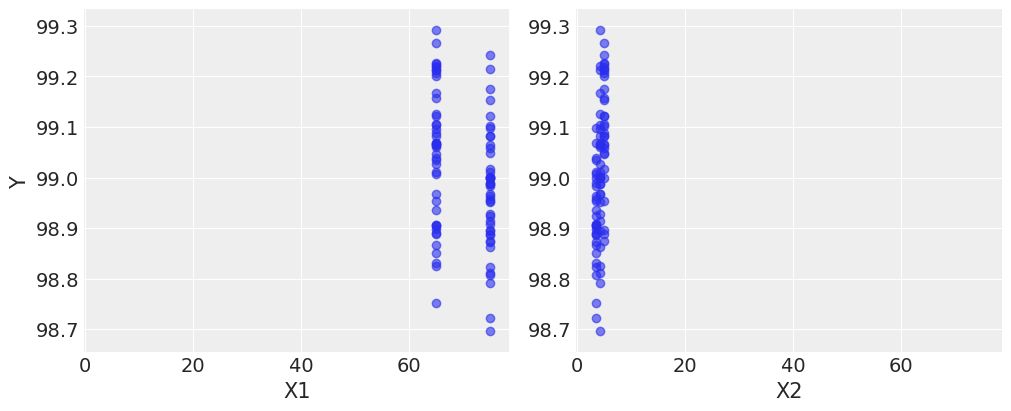

In [7]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2")

In [8]:
og_model = pm.Model()

with og_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=98, sigma=3)
    beta = pm.Normal("beta", mu=0, sigma=2, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=3)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [9]:
with og_model:
    trace = pm.sample(500, return_inferencedata = False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2345 seconds.


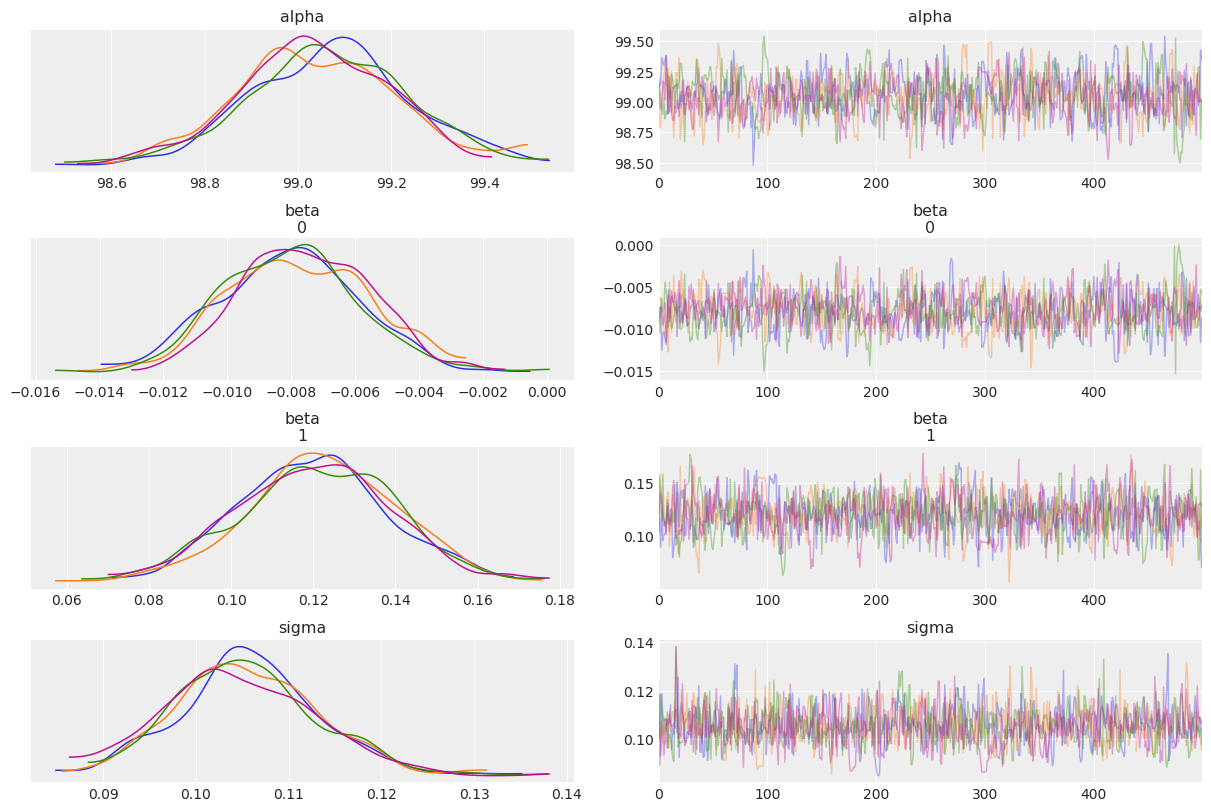

In [10]:
with og_model:
    az.plot_trace(trace);

In [11]:
with og_model:
    display(az.summary(trace, round_to=3))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,99.050,0.169,98.713,99.358,0.006,0.004,801.856,801.856,803.106,903.811,1.005
beta[0],-0.008,0.002,-0.012,-0.004,0.000,0.000,856.924,856.300,858.089,924.378,1.006
beta[1],0.121,0.018,0.088,0.155,0.001,0.000,1007.714,1007.398,1008.444,865.977,1.001
sigma,0.105,0.008,0.091,0.120,0.000,0.000,999.594,999.594,932.896,624.749,1.002


C:\Users\Topher\AppData\Local\Programs\Python\Python37\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D8B726AC88>,
      dtype=object)

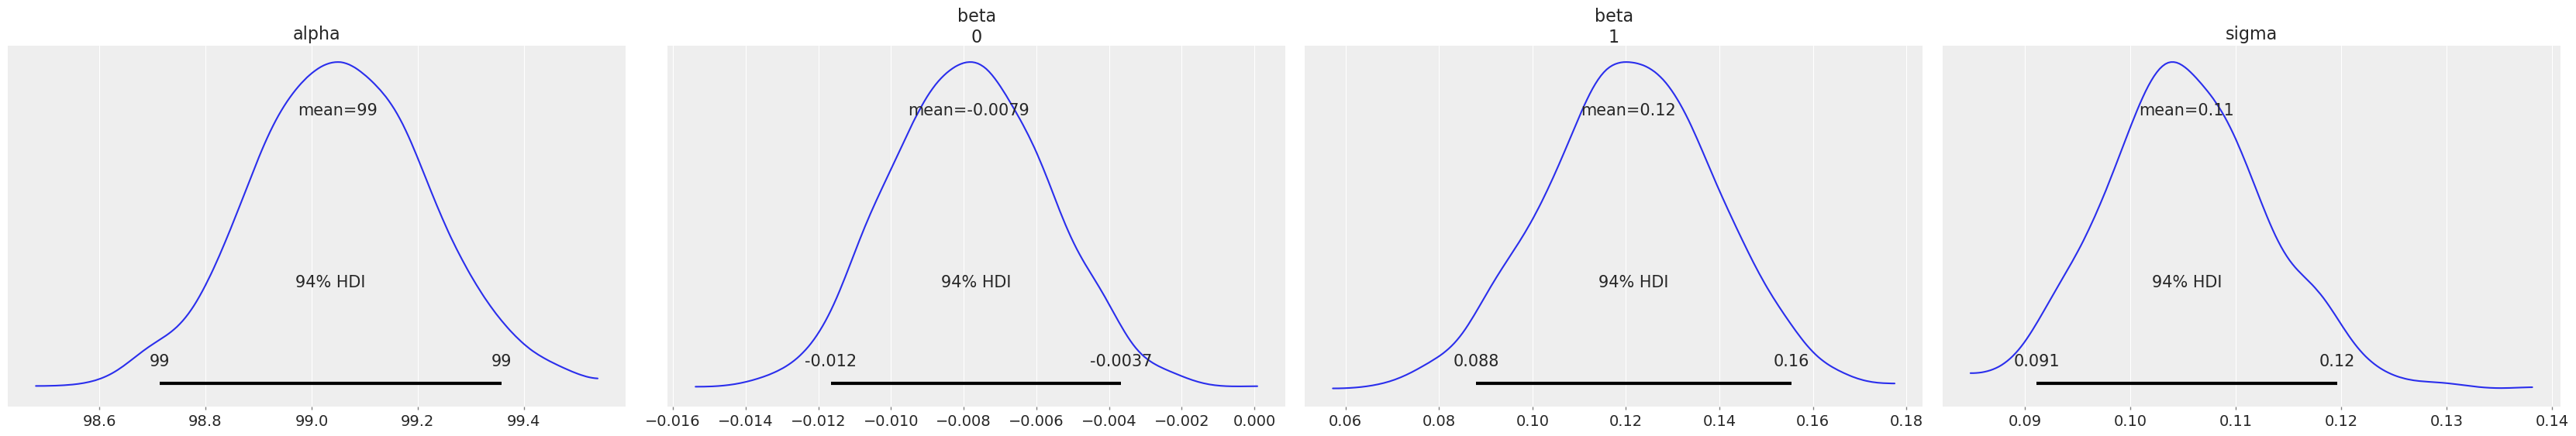

In [17]:
pm.plot_posterior(trace)

In [19]:
#pickle the trace
with open('poq_trace.pkl', 'wb') as f:
    pickle.dump(trace, f)


#load trace back in.
#trace = pickle.load(open('poq_trace.pkl', 'rb'))

In [20]:
pm.save_trace(trace, 'poq_trace.trace')

'poq_trace.trace'

In [ ]:
def prep_data(df, col1, col2):
    """
    Prepare data for pymc3 and return mean mu and sigma
    """
    y1 = np.array(df[col1])
    y2 = np.array(df[col2])

    y = pd.DataFrame(dict(value=np.r_[y1, y2], 
                          group=np.r_[[col1]*len(y1), 
                            [col2]*len(y2)]))
    mu = y.value.mean()
    sigma = y.value.std() * 2
    
    return y, mu, sigma

In [ ]:



#Set the paramaters for the Bayesian Analysis
y, mu, sigma = prep_data(data_df, 'group1', 'group2')
μ_m = y.value.mean()
μ_s = y.value.std() * 2

with pm.Model() as model:
    """
    The priors for each group.
    """
    group1_mean = pm.Normal('group1_mean', μ_m, sd=μ_s)
    group2_mean = pm.Normal('group2_mean', μ_m, sd=μ_s)


#Set Uniform distribution for the standard deviation guesses.
σ_low = 1
σ_high = 20

with model:
    group1_std = pm.Uniform('group1_std', lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform('group2_std', lower=σ_low, upper=σ_high)

with model:
    """
    Prior for ν is an exponential (lambda=29) shifted +1.
    """
    ν = pm.Exponential('ν_min_one', 1/29.) + 1

with model:
    """
    Transforming standard deviations to precisions (1/variance) to calculate the likelihoods
    """
    λ1 = group1_std**-2
    λ2 = group2_std**-2

    group1 = pm.StudentT('group1', nu=ν, mu=group1_mean, lam=λ1, observed=y1)
    group2 = pm.StudentT('group2', nu=ν, mu=group2_mean, lam=λ2, observed=y2)

with model:
    """
    The effect size is the difference in means/pooled estimates of the standard deviation.
    The Deterministic class represents variables whose values are completely determined
    by the values of their parents.
    """
    diff_of_means = pm.Deterministic('difference of means',  group2_mean - group1_mean)
    diff_of_stds = pm.Deterministic('difference of stds',  group2_std - group1_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((group2_std**2 + group1_std**2) / 2))

with model:
    '''
    generate a model that takes sample from 2000 values stepped via the No U-Turn Sampling algorithm
    NUTS
    '''
    step = pm.NUTS()
    trace = pm.sample(2000, tune=500, init=None, step=step, cores=1)

#Plotting the posterior using the sample trace with a 50% burn in to remove transient effects of MCMC.
pm.plot_posterior(trace[1000:],
                  varnames=['difference of means', 'difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb');

plt.show()